In [ ]:
import numpy as np
import xarray as xr
from scipy.stats import norm
from dask.distributed import Client
import dask.delayed
import time
import pandas as pd 
import dask
import os
from dask.distributed import LocalCluster
#os.chdir("/tank/crop_modelling/Daniel/NecessaryM1InternshipCode/ProjectRice")

#start cluster
#cluster = LocalCluster(n_workers=os.cpu_count() - 5 ,threads_per_worker=1)          # Fully-featured local Dask cluster: forward port 8787 to via vscode to see dashboard
#client = cluster.get_client()

'''

This code's purpose is to estimate the infra-annual crop production based on the ISIMIP3a model which was selected in ISIMIP3a_SpatialYieldIntercomparison.

The final temporal resolution will be either daily or monthly.

'''

def process_netcdf_data(yield_path, maturity_path):
    """
    Processes NetCDF files in a folder, extracts yield and maturity data, and creates a Pandas DataFrame.

    Args:
        yield_path: The path to the folder containing the yield .nc files.
        maturity_path: The path to the folder containing the maturity .nc files.

    Returns:
        A Pandas DataFrame containing the processed data. Returns an empty DataFrame if no .nc files are found.
    """
    yield_files = [f for f in os.listdir(yield_path) if f.endswith(".nc")]
    maturity_files = [f for f in os.listdir(maturity_path) if f.endswith(".nc")]

    if not yield_files:
        print("No .nc files found in the specified yield folder.")
        return pd.DataFrame()  # Return an empty DataFrame

    # Create a dictionary to store parsed metadata of maturity files
    maturity_dict = {}

    for file_name in maturity_files:
        parts = file_name[:-3].split("_")  # Remove .nc and split
        if len(parts) != 10:
            continue  # Skip files with incorrect formatting

        model, climate_forcing, climate_scenario, soc_scenario, sens_scenario, variable_crop_irrigation, region, time_step, start_year, end_year = parts
        variable, crop_irrigation = variable_crop_irrigation.split("-", 1)
        crop, irrigation = crop_irrigation.rsplit("-", 1)

        # Store the file path using parsed metadata as key
        key = (model, climate_forcing, climate_scenario, soc_scenario, sens_scenario, crop, irrigation, region, time_step, start_year, end_year)
        maturity_dict[key] = os.path.join(maturity_path, file_name)

    data = []

    for file_name in yield_files:
        try:
            yield_file_path = os.path.join(yield_path, file_name)
            ds_yield = xr.open_dataset(yield_file_path, decode_times=False)

            # Extract yield variable
            variable_names = list(ds_yield.data_vars)
            if not variable_names:
                print(f"Warning: No data variables found in {file_name}. Skipping.")
                continue

            yield_variable_name = variable_names[0]
            yield_data = ds_yield[yield_variable_name]

            # Parse filename
            parts = file_name[:-3].split("_")
            if len(parts) != 10:
                print(f"Warning: Unexpected filename format for {file_name}. Skipping.")
                continue

            model, climate_forcing, climate_scenario, soc_scenario, sens_scenario, variable_crop_irrigation, region, time_step, start_year, end_year = parts
            variable, crop_irrigation = variable_crop_irrigation.split("-", 1)
            crop, irrigation = crop_irrigation.rsplit("-", 1)

            # Try to find the matching maturity file
            key = (model, climate_forcing, climate_scenario, soc_scenario, sens_scenario, crop, irrigation, region, time_step, start_year, end_year)
            maturity_data = None

            if key in maturity_dict:
                ds_maturity = xr.open_dataset(maturity_dict[key], decode_times=False)
                maturity_variable_name = list(ds_maturity.data_vars)[0]  # Assuming the first variable is correct
                maturity_data = ds_maturity[maturity_variable_name]
                ds_maturity.close()

            # Append to data list
            data.append({
                'model': model,
                'climate_forcing': climate_forcing,
                'climate_scenario': climate_scenario,
                'soc_scenario': soc_scenario,
                'sens_scenario': sens_scenario,
                'variable': variable,
                'crop': crop,
                'irrigation': irrigation,
                'region': region,
                'time_step': time_step,
                'start_year': start_year,
                'end_year': 2016,
                'yield_data': yield_data,
                'maturity_data': maturity_data  # Include maturity data
            })

            ds_yield.close()

        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    # Create DataFrame
    df = pd.DataFrame(data)

    median_df = df.groupby([
        'climate_forcing', 'climate_scenario', 'soc_scenario', 'sens_scenario',
        'variable', 'crop', 'irrigation', 'region', 'time_step', 'start_year', 'end_year'
    ]).agg(
        yield_data=('yield_data', lambda x: xr.concat(x, dim="model").median(dim="model")),
        maturity_data=('maturity_data', lambda x: xr.concat([d for d in x if d is not None], dim="model").median(dim="model") 
                    if any(d is not None for d in x) else None)
    ).reset_index()

    # Add median model entry
    median_df['model'] = 'median'

    final_df = pd.concat([df, median_df], ignore_index=True)

    return df[df['model']=='pdssat'] #final_df #only need median df for now.

#Load and process data from the ISIMIP3b-YieldModels folder
yield_path = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\AgriculturalProduction\ISIMIP3a-Yield"  
maturity_path = r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\AgriculturalProduction\ISIMIP3a-MatyDay"  
ISIMIP_Yields_df = process_netcdf_data(yield_path, maturity_path)


In [17]:
ISIMIP_Yields_df.crop.unique()

array(['mai'], dtype=object)

In [ ]:


def custom_normpdf(x,loc,scale):
    '''
    Custom normal pdf function that sets the values of the pdf to 0 before and after the maturity day, then normalizes the pdf.   
    '''
    result = norm.pdf(x, loc=loc, scale=scale)
    if ~np.isnan(loc):
        loc = int(loc)
        min = np.minimum(scale,loc).astype(int)
        max = np.minimum(scale,365-loc).astype(int)
        print(loc-min)
        result[0:loc-min] = 0
        result[loc+max:] = 0
        #now upscale the daily to monthly pdf
        days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        # Create an index to slice the data based on month lengths
        start_idx = 0
        sum_months = []
        # Loop through each month and sum the data for that month
        for days in days_in_months:
            end_idx = start_idx + days
            sum_months.append(np.sum(result[start_idx:end_idx]))
            start_idx = end_idx
        # Convert the list of sums into a numpy array for convenience
        sum_months = np.array(sum_months)
        sum_months /= np.sum(sum_months)
        return sum_months

#@dask.delayed
def temporallydownscale_cropyield(maturity_data,yield_data):
    '''
    Temporally downscales the crop yield data to a daily time series based on the maturity day.
    '''
    #results = np.zeros((12,len(yield_data)),dtype=int)
    days = np.arange(1, 366)  # Days of the year
    results = [ custom_normpdf(days, loc=maturity_day, scale=10)*yields for maturity_day,yields in zip(maturity_data,yield_data)]
    return np.array(results)

def Temporally_Downscale(maturity_data,yield_data):
    """
    Generate a 365-day time series based on a normal distribution centered on maturity day.

    Args:
        yield_data (xarray.DataArray): The yield for the year.
        maturity_day (xarray.DataArray): The day of year when the crop matures.

    Returns:
        xarray.DataArray: A 365-day time series for the year.
    """
 
    # Standard deviation to achieve ~20-day spread
    std_dev = 20 / 2  # 95% confidence within ~20 days
    lats,lons = np.where(np.isnan(maturity_data.values).sum(axis=0)<maturity_data.values.shape[0]) #lats, lons are the indices of the pixels that have no missing values   
    latitudes,longitudes = maturity_data.lat.values[lats],maturity_data.lon.values[lons] #latitudes and longitudes of the pixels that have no missing values
    pixel_list = np.arange(len(lons))
    maturitys = np.array([maturity_data.values[:,i,j] for i,j in zip(lats,lons)]) #use the indices to get the maturity data for the pixels that have no missing values
    yields = np.array([yield_data.values[:,i,j] for i,j in zip(lats,lons)]) #use the indices to get the yield data for the pixels that have no missing values
    results = []


    #
    #Compute, either with dask or without dask, the temporally downscaled crop yield data for the pixels in the subset_pixel_list
    #
    BurkinaFaso_pixel_list = pixel_list[ np.where( (latitudes >= 9) & (latitudes <= 15) & (longitudes >= -6) & (longitudes <= 3) ) ]
    #africa_pixel_list = pixel_list[ np.where( (latitudes >= -35) & (latitudes <= 37) & (longitudes >= -25) & (longitudes <= 55) ) ]

    start =time.time()
    for pixel in BurkinaFaso_pixel_list:
        results.append(temporallydownscale_cropyield(maturity_data=maturitys[pixel,-30:-1],yield_data=yields[pixel,-30:-1]))

    #output = client.compute(results)
    #final_outputs = np.array([ress.result() for ress in output])
    final_outputs = np.array(results)
    end = time.time()
    print(start-end)


    ##
    ##Save the temporally downscaled crop yield data as a netcdf file
    ##

    # Generate the latitude and longitude grid
    # Define years and days
    years = np.arange(1901, 2016)[-30:-1].astype(int)  # Reduced above earlier. no need for such a long time series.
    origin_year = years[0]  # Or any other year you are using.
    origin_date = pd.to_datetime(f'{origin_year}-01-01')
    months = np.arange(1,12+1,1).astype(int)
    #
    #finally, save as netcdf4 filae
    #
    subset_latitudes = latitudes[BurkinaFaso_pixel_list]
    subset_longitudes = longitudes[BurkinaFaso_pixel_list]
    #create gridded data
    yieldts_gridded = np.empty((len(np.unique(subset_latitudes)),len(np.unique(subset_longitudes)),len(years),len(months)))*np.nan
    for i in range(len(BurkinaFaso_pixel_list)): #length pixel list because that is the spatial dimension collapsed, and we fill time dimensions all at once
        yieldts_gridded[np.where(np.unique(subset_latitudes)==subset_latitudes[i])[0][0],np.where(np.unique(subset_longitudes)==subset_longitudes[i])[0][0],:,:] = final_outputs[i,:,:]
    print('part')
    # Setting up coordinates and dimensions
    coords = {
        'lat': np.unique(subset_latitudes),
        'lon': np.unique(subset_longitudes),
        'year': years,
        'months': months,
    }
    dims = ('lat','lon', 'year', 'months')
    # Creating DataArray
    data_array = xr.DataArray(yieldts_gridded, coords=coords, dims=dims) #multiply by 100 to convert from fraction to percent.
    # Creating Dataset
    dataset = xr.Dataset({
        'yield': data_array
    })
    return dataset

In [83]:
yield_data = ISIMIP_Yields_df[ISIMIP_Yields_df['irrigation']=='noirr'].iloc[0].yield_data #only one model, the median, was returend on calling ISIMIP_Yields_df=process...()
maturity_data = ISIMIP_Yields_df[ISIMIP_Yields_df['irrigation']=='noirr'].iloc[0].maturity_data 
rainfed_yields = Temporally_Downscale(maturity_data,yield_data)

yield_data = ISIMIP_Yields_df[ISIMIP_Yields_df['irrigation']=='firr'].iloc[0].yield_data #only one model, the median, was returend on calling ISIMIP_Yields_df=process...()
maturity_data = ISIMIP_Yields_df[ISIMIP_Yields_df['irrigation']=='firr'].iloc[0].maturity_data 
irrigated_yields = Temporally_Downscale(maturity_data,yield_data)

89
94
92
90
95
95
92
96
94
94
91
94
96
93
93
91
95
91
92
96
93
94
95
95
91
92
92
93
92
90
94
93
90
93
93
93
96
95
95
92
95
97
94
94
91
96
92
93
95
94
93
95
95
92
93
93
94
93
89
94
93
89
93
98
92
97
94
95
91
94
97
93
94
101
95
92
93
97
94
93
99
95
92
93
93
93
93
89
94
93
89
93
98
92
97
94
95
91
93
97
93
93
90
95
92
93
98
94
93
99
95
92
92
93
93
92
100
105
104
101
104
105
105
109
105
106
101
103
109
104
105
114
104
104
102


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [ ]:
#left off here: the AGMIP model-based estimates of yield in conjuction with MAPSPAM harvest areas are strongly biased (5x less yield than FAO) and don't accurately correlate with observed variability either. 

In [18]:
Irrigated_Maize_Area =  xr.open_dataset(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\AgriculturalProduction\Global_Geotiff\spam_2000-2020_linearinterpolation_global_harvestedarea_MAIZE_I.nc")
Rainfed_Maize_Area =  xr.open_dataset(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\AgriculturalProduction\Global_Geotiff\spam_2000-2020_linearinterpolation_global_harvestedarea_MAIZE_R.nc")

In [37]:
Rainfed_Maize_Area['band_data'][0:15,np.where(Rainfed_Maize_Area.y ==rainfed_yields.lon)[0],np.where(Rainfed_Maize_Area.x ==rainfed_yields.lat)[0]]

<xarray.DataArray 'band_data' (year: 15, y: 18, x: 12)> Size: 26kB
[3240 values with dtype=float64]
Coordinates:
  * x            (x) float64 96B 9.25 9.75 10.25 10.75 ... 13.75 14.25 14.75
  * y            (y) float64 144B 2.75 2.25 1.75 1.25 ... -4.75 -5.25 -5.75
    spatial_ref  int32 4B ...
  * year         (year) int32 60B 2000 2001 2002 2003 ... 2011 2012 2013 2014
Attributes:
    AREA_OR_POINT:  Area

In [69]:
predicted_irrigated_production = Irrigated_Maize_Area['band_data'][0:15,np.where(Irrigated_Maize_Area.y ==irrigated_yields.lon)[0],np.where(Irrigated_Maize_Area.x ==irrigated_yields.lat)[0]].values*irrigated_yields['yield'][:,:,14:,:].sum(axis=3).transpose().values
predicted_rainfed_production = Rainfed_Maize_Area['band_data'][0:15,np.where(Rainfed_Maize_Area.y ==rainfed_yields.lon)[0],np.where(Rainfed_Maize_Area.x ==rainfed_yields.lat)[0]].values*rainfed_yields['yield'][:,:,14:,:].sum(axis=3).transpose().values

In [70]:
pred_maize_prod=predicted_rainfed_production.sum(axis=1).sum(axis=1) +predicted_irrigated_production.sum(axis=1).sum(axis=1)

In [71]:
obs_maize_prod_fao = np.array([
    423494, 606291, 653081, 665508, 481474, 
    799052, 866664, 553874, 1013634, 894558, 
    1133452, 1076753, 1556316, 1585418, 1433085
])


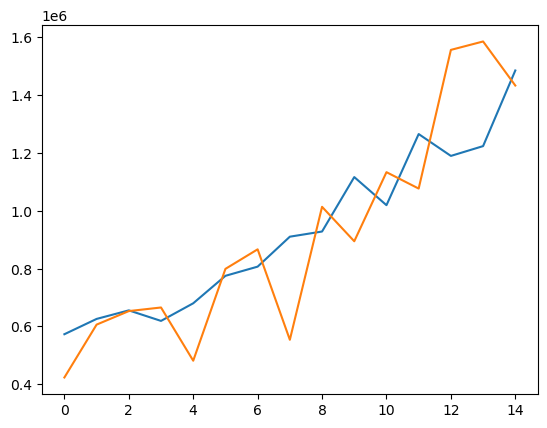

In [77]:
plt.plot(pred_maize_prod*5);plt.plot(obs_maize_prod_fao)

array([ 31302.01188033,  49773.80589746,  76939.67310933, 108587.06347464,
       340758.28145116, 289933.18281846, 362360.60670316, 497287.35673501,
       401616.73656087, 198643.69963122, 273536.15328176, 141031.26444588])

In [ ]:
# save to csv for visualization with keplergl
dataset.isel(year=5).drop("year")['yield'].fillna(0).to_dataframe().to_csv('yield_ts_1986.csv')

In [ ]:
import csv
import shapefile

def csv_to_shapefile(csv_filepath, shapefile_filepath, lat_field, lon_field, shape_type=shapefile.POINT):
    """
    Converts a CSV file with lat, lon, year, day, yield to a shapefile.

    Args:
        csv_filepath (str): Path to the input CSV file.
        shapefile_filepath (str): Path to the output shapefile (without extension).
        lat_field (str): Name of the column containing the latitude coordinates.
        lon_field (str): Name of the column containing the longitude coordinates.
        shape_type (int): The shape type for the shapefile (e.g., shapefile.POINT).
    """
    try:
        with open(csv_filepath, 'r', newline='', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            fields = reader.fieldnames  # Get field names from the CSV header

            # Create a shapefile writer
            w = shapefile.Writer(shapefile_filepath, shape_type)

            # Add fields to the shapefile (same as the CSV header)
            for field_name in fields:
                # Assuming all fields are strings (adjust as needed)
                if field_name in [lat_field, lon_field]:
                    continue #skip lat and lon as they are used for the geometry.
                w.field(field_name, 'C', size=254)  # 'C' for character, adjust size as needed

            # Iterate through the CSV rows and add points to the shapefile
            for i,row in enumerate(reader):
                print(i)
                try:
                    lon = float(row[lon_field])
                    lat = float(row[lat_field])
                    if shape_type == shapefile.POINT:
                        w.point(lon, lat)

                    # Add the attributes from the CSV row to the shapefile record, skipping lat and lon
                    record_data = [row[field] for field in fields if field not in [lat_field, lon_field]]
                    w.record(*record_data)

                except ValueError:
                    print(f"Skipping row due to invalid coordinates: {row}")
                except KeyError as e:
                    print(f"Key error: {e}. Check if column names are correct in CSV.")
                    return
                except Exception as e:
                    print(f"An unexpected error occurred: {e}. Skipping row.")

            # Save the shapefile
            w.close()

            print(f"Shapefile created successfully: {shapefile_filepath}.shp")

    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_filepath}")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (replace with your file paths):
csv_file = 'yield_ts_2007.csv'  # Replace with your CSV file path
shapefile_output = 'yield_data' # Replace with your desired shapefile output name (without .shp)
lat_column = 'lat'
lon_column = 'lon'

# Create a shapefile of points
csv_to_shapefile(csv_file, shapefile_output, lat_column, lon_column, shapefile.POINT)